## Imports all required packages for Data cleansing and modeling 

In [2]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier  as GBC
from xgboost.sklearn import XGBClassifier as XGB
from apyori import apriori as ap
import matplotlib.pyplot as plt
from datetime import datetime
import time
import json
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings("ignore")

In [5]:
cfdc_new = pd.read_csv('results.csv')

In [3]:
cfdc_new = pd.read_csv('C:/Users/nathan.ellis/Documents/Python Scripts/results.csv')

new_columns = ['user','date', 'goal', 'revenue', 'session_count', 'session_duration', 'device',
               'channel', 'page_viewed', 'time', 'type', 'page_title', 'page_url', 'title']

cfdc_new.columns = new_columns

cfdc_new.date = pd.to_datetime(cfdc_new.date)

cfdc = cfdc_new.copy()

In [4]:
cfdc.time

0       11:46 PM
1       11:46 PM
2       11:22 PM
3       11:22 PM
4       11:22 PM
5       11:22 PM
6        7:00 PM
7        7:00 PM
8        7:35 AM
9        7:35 AM
10       7:23 AM
11       7:20 AM
12       7:20 AM
13      10:00 PM
14      10:00 PM
15      10:12 PM
16      10:12 PM
17       8:59 PM
18       8:59 PM
19       7:50 PM
20       7:50 PM
21       7:40 PM
22       7:39 PM
23       6:12 PM
24       6:12 PM
25       6:11 PM
26       6:11 PM
27       6:11 PM
28       6:11 PM
29       1:50 PM
          ...   
1277     8:35 PM
1278     8:35 PM
1279     4:13 PM
1280     4:13 PM
1281     4:13 PM
1282     4:13 PM
1283     2:19 PM
1284     2:19 PM
1285     5:41 AM
1286     5:41 AM
1287    10:04 PM
1288    10:04 PM
1289     8:21 PM
1290     8:21 PM
1291     7:16 PM
1292     7:16 PM
1293     6:55 PM
1294     6:55 PM
1295     6:55 PM
1296     6:55 PM
1297     6:07 PM
1298     6:07 PM
1299     6:07 PM
1300     6:07 PM
1301     2:55 PM
1302     2:55 PM
1303     2:54 PM
1304     2:54 

In [3]:
title_list = list(cfdc.page_title)

c = []

for i in range(0, len(title_list), 1):
    a = title_list[i]
    monday = a.find('Monday')
    tuesday = a.find('Tuesday')
    wednesday = a.find('Wednesday')
    thursday = a.find('Thursday')
    friday = a.find('Friday')
    saturday = a.find('Saturday')
    sunday = a.find('Sunday')
    
    if (sunday >=0) | (monday >=0)| (tuesday >=0)| (wednesday >=0)| (thursday >=0)| (friday >=0)| (saturday >=0):  
        b = title_list[i] 
        b = b.replace(a, 'Workout for THAT Day')
        c.append(b)
    else:
        c.append(a)
cfdc['page_title'] = c

### New session count 

#### 1) Function creates and enumerates each session that the user genreates while on CFDC website

In [4]:

### I had to use this instead of np.where because of labeling the unique sessions

cfdc['new_session'] = 0
a = 0
for i in range(0, len(cfdc)+1):
    if (cfdc.page_viewed[i:i+1].values > 0):
        a = a+1
        cfdc['new_session'][i:i+1]= a
    else: 
        cfdc['new_session'][i:i+1] = np.nan


### Backfills missing data values 
#### 1) Needed to backfill values that were missing in order to correctly sort data into user visit groupings

In [5]:
cfdc = cfdc.drop(['title', 'type', 'goal', 'revenue'],axis =1)

cfdc = cfdc.fillna(method = 'ffill')

cfdc.date = cfdc.date.fillna(method = 'ffill')

cfdc = cfdc.drop_duplicates(subset = None, keep = 'first', inplace = False)

cfdc = cfdc.reset_index()

### Creates time split function and time labels 

#### 1) Creates time splitting functions for the time the user visited a webpage and the duration of time the user stayed on the webpage. This was done to create the proper format for model utilization

In [6]:
def timesplit(time):

    c = time.split()

    d = list(c[0])
    
    e = list(c[1])

    d.remove(':')

    if len(d) > 3:
        final = int(d[0]+d[1])
        
    elif len(d) <= 3:
        final = int(d[0])
        
    if e[0] == 'P':
        final = final + 12
    else:
        final = final 
    
    return(final)


In [7]:
def timesplit_duration(time):

    c = time.split()

    d = list(c[0])
    
    d.remove(':')

    if len(d) > 3:
        final = int(d[0]+d[1])
        
    elif len(d) <= 3:
        final = int(d[0])
        
    
    return(final)


In [8]:
final_time = []

for i in range(0, len(cfdc)):
    final = timesplit_duration(cfdc.session_duration[i])
    
    final_time.append(final)
    
cfdc['duration_labels'] = final_time


In [9]:
final_time = []

for i in range(0, len(cfdc)):
    final = timesplit(cfdc.time[i])
    
    final_time.append(final)
    
cfdc['time_labels'] = final_time


### Filters out for only visits in which the user hit more than one page

#### 1) Because basic Google Analytics can provide the descriptive analytics behind what pages we hit only one time, the focus was scoped to only provide predictions AFTER the user had landed on the initial page. Therefore, the pages viewed needed to be > 2 per session

In [10]:
cfdc = cfdc[cfdc.page_viewed > 2]

### Reverses the dataframe and adds sequence count

#### 1) Arranges the pages visited in ascending order

In [11]:
cfdc['sequence'] = cfdc.iloc[::-1].groupby('new_session')['new_session'].cumcount()+1
    


### Creates unique category labels for features

#### 1) The models need to utilize unique label identifiers to find correlations within the data. Therefore, category labels are utilized. 

In [179]:
cfdc['page_title'] = cfdc['page_title'].astype('category')

cfdc['page_titles'] = cfdc['page_title'].cat.codes

#cfdc.page_title[cfdc['page_titles'] == 14]

#cfdc['page_titles'].value_counts()

0      Workout for THAT Day
1      Workout for THAT Day
14     Workout for THAT Day
23     Workout for THAT Day
27     Workout for THAT Day
32     Workout for THAT Day
45     Workout for THAT Day
48     Workout for THAT Day
49     Workout for THAT Day
50     Workout for THAT Day
52     Workout for THAT Day
54     Workout for THAT Day
57     Workout for THAT Day
60     Workout for THAT Day
61     Workout for THAT Day
64     Workout for THAT Day
67     Workout for THAT Day
74     Workout for THAT Day
75     Workout for THAT Day
76     Workout for THAT Day
77     Workout for THAT Day
78     Workout for THAT Day
79     Workout for THAT Day
83     Workout for THAT Day
84     Workout for THAT Day
88     Workout for THAT Day
90     Workout for THAT Day
116    Workout for THAT Day
117    Workout for THAT Day
120    Workout for THAT Day
               ...         
531    Workout for THAT Day
547    Workout for THAT Day
548    Workout for THAT Day
549    Workout for THAT Day
550    Workout for T

In [184]:
### Checking for Workout for THAT Day
cfdc.page_title_labels = np.where((cfdc.page_titles == 14)|(cfdc.page_titles == 15), 1, 0)

### Features and Discrete 

#### 1) The main features utilized in prediciting the user experience.

In [228]:
features = ['sequence', 'channel', 'time_labels', 'device', 'duration_labels', 'new_session', 'page_title_labels']

discrete = ['page_title_labels']

all_data = cfdc[features]

X_train = all_data[features]
seq_dums = pd.get_dummies(all_data.sequence, prefix = 'seq')
time_dums = pd.get_dummies(all_data.time_labels, prefix = 'time')
duration_dums = pd.get_dummies(all_data.duration_labels, prefix = 'duration')
device_dums = pd.get_dummies(all_data.device)
channel_dums = pd.get_dummies(X_train.channel)
all_data = pd.concat([all_data.page_title_labels, all_data.new_session, all_data.duration_labels, all_data.sequence, time_dums, seq_dums, device_dums, channel_dums], axis = 1)


In [1]:
cfdc

NameError: name 'cfdc' is not defined

In [230]:
session_list = list(cfdc.new_session.unique())

acc_list_xg = []
acc_list_rf = []
acc_list_gb = []
acc_list_combo = []

n_estimators = 100

for i in session_list:
    
    train = all_data[all_data.new_session != i]
    test = all_data[all_data.new_session == i]
    
        
    X_train = train
    X_train = X_train.drop(['new_session', 'page_title_labels'], axis = 1)
    y_train = train[discrete].values.ravel()
    
    X_test = test
    X_test= X_test.drop(['new_session', 'page_title_labels'], axis = 1)
    y_test = test[discrete].values.ravel()
    
    RF = RFC(n_estimators = n_estimators)
    GB = GBC(n_estimators = n_estimators)
    XG = XGB(n_estimators = n_estimators)

    RF.fit(X_train, y_train)
    GB.fit(X_train, y_train)
    XG.fit(X_train, y_train)

    rf_pred = RF.predict(X_test)
    gb_pred = GB.predict(X_test)
    xg_pred = XG.predict(X_test)

    accuracy_rf = RF.score(X_test, y_test)
    accuracy_gb = GB.score(X_test, y_test)
    accuracy_xg = XG.score(X_test, y_test)
    
    ##if len(y_test) < 3:
      #  acc_list.append(accuracy_rf)
   # else:
    acc_list_xg.append(accuracy_xg)
    acc_list_rf.append(accuracy_rf)
    acc_list_gb.append(accuracy_gb)
     

    print('KyleBoost:', accuracy_xg)
    print('Random Forest:',accuracy_rf)
    print('Gradient Boost:',accuracy_gb) 
    print('####')
    print('XG', xg_pred)
    print('test', y_test)
    print('####')
    
    
print('Overall XGBoost:', sum(acc_list_xg)/len(acc_list_xg))
print('Overall Random Forest:', sum(acc_list_rf)/len(acc_list_rf))
print('Overall Gradient Boost:', sum(acc_list_gb)/len(acc_list_gb)) 

    

KyleBoost: 0.6666666666666666
Random Forest: 0.3333333333333333
Gradient Boost: 0.6666666666666666
####
XG [1 1 0]
test [1 1 1]
####
KyleBoost: 0.0
Random Forest: 0.5
Gradient Boost: 0.0
####
XG [0 0]
test [1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1 1]
test [1 1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1 1]
test [1 1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1]
test [1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1 1 1]
test [1 1 1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1]
test [1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1]
test [1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1]
test [1 1]
####
KyleBoost: 0.5
Random Forest: 0.5
Gradient Boost: 0.5
####
XG [1 1 1 1]
test [1 0 0 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1]
test [1 1]
####
Kyl

KyleBoost: 1.0
Random Forest: 0.6666666666666666
Gradient Boost: 1.0
####
XG [1 1 1]
test [1 1 1]
####
KyleBoost: 0.25
Random Forest: 0.5
Gradient Boost: 0.25
####
XG [1 1 1 1 1 1 1 1]
test [0 0 1 0 0 0 0 1]
####
KyleBoost: 0.6666666666666666
Random Forest: 0.3333333333333333
Gradient Boost: 0.6666666666666666
####
XG [1 1 0]
test [1 1 1]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1]
test [1 1]
####
KyleBoost: 0.5
Random Forest: 0.25
Gradient Boost: 0.5
####
XG [1 1 1 1]
test [1 0 0 1]
####
KyleBoost: 1.0
Random Forest: 0.25
Gradient Boost: 1.0
####
XG [1 1 1 1]
test [1 1 1 1]
####
KyleBoost: 0.6666666666666666
Random Forest: 0.3333333333333333
Gradient Boost: 0.6666666666666666
####
XG [1 1 1]
test [1 1 0]
####
KyleBoost: 0.3333333333333333
Random Forest: 0.3333333333333333
Gradient Boost: 0.3333333333333333
####
XG [1 1 1]
test [0 1 0]
####
KyleBoost: 0.5
Random Forest: 0.5
Gradient Boost: 0.5
####
XG [1 1 1 1]
test [1 1 0 0]
####
KyleBoost: 0.25
Random For

KyleBoost: 0.4
Random Forest: 0.2
Gradient Boost: 0.4
####
XG [0 0 0 0 0]
test [1 1 0 1 0]
####
KyleBoost: 1.0
Random Forest: 1.0
Gradient Boost: 1.0
####
XG [1 1 1 0]
test [1 1 1 0]
####
KyleBoost: 0.5
Random Forest: 0.5
Gradient Boost: 0.5
####
XG [1 1]
test [1 0]
####
KyleBoost: 0.75
Random Forest: 0.25
Gradient Boost: 0.75
####
XG [1 1 1 1]
test [1 1 1 0]
####
KyleBoost: 0.5
Random Forest: 0.5
Gradient Boost: 0.5
####
XG [1 1]
test [1 0]
####
KyleBoost: 0.5
Random Forest: 0.5
Gradient Boost: 0.5
####
XG [1 1]
test [0 1]
####
KyleBoost: 1.0
Random Forest: 0.3333333333333333
Gradient Boost: 0.3333333333333333
####
XG [1 1 1]
test [1 1 1]
####
KyleBoost: 1.0
Random Forest: 0.5
Gradient Boost: 1.0
####
XG [1 1]
test [1 1]
####
KyleBoost: 0.5
Random Forest: 0.5
Gradient Boost: 0.5
####
XG [1 1]
test [1 0]
####
Overall XGBoost: 0.7157804232804236
Overall Random Forest: 0.6342328042328044
Overall Gradient Boost: 0.7036904761904765


### Model Value Counts

  #### 1) This counts the accuracies of the model against the test data. Again, the overall goal was to achieve a higher number of 100% accuracies than any other accuracy. This means that the model was 100% accurate in predicting not only the pages hit within the website but also the order that they were hit.
  
  #### 2) As we can see, the model had a 100% accuracy count of 50. The amount that the model was >75% accurate in predicting was approximately 32% of the time. 

In [231]:
rf = pd.DataFrame(acc_list_xg)
                  
rf.columns = ['avg']

rf.avg.value_counts()

1.000000    82
0.500000    38
0.666667    22
0.333333     8
0.250000     7
0.000000     7
0.750000     6
0.400000     4
0.200000     2
0.600000     1
0.800000     1
0.714286     1
0.142857     1
Name: avg, dtype: int64

                Importance %
Questions                   
Social              0.170718
Direct              0.121882
Organic Search     0.0804376
Referral           0.0773877
sequence           0.0731271
seq_3              0.0496042
time_7              0.048839
duration_labels    0.0468385
time_23            0.0428509
time_9             0.0385225
time_17            0.0351104
time_6             0.0306011
seq_2              0.0302698
time_14            0.0285059
desktop            0.0247059
seq_4              0.0218101
time_19            0.0178606
time_15            0.0169357
time_21            0.0151977
time_4             0.0146875
time_13           0.00823223
seq_5             0.00587549
time_16                    0
seq_7                      0
time_1                     0
time_3                     0
mobile                     0
time_10                    0
seq_8                      0
time_11                    0
seq_6                      0
time_18                    0
time_5        

Text(0.5, 1.0, 'Feature Importances for the ')

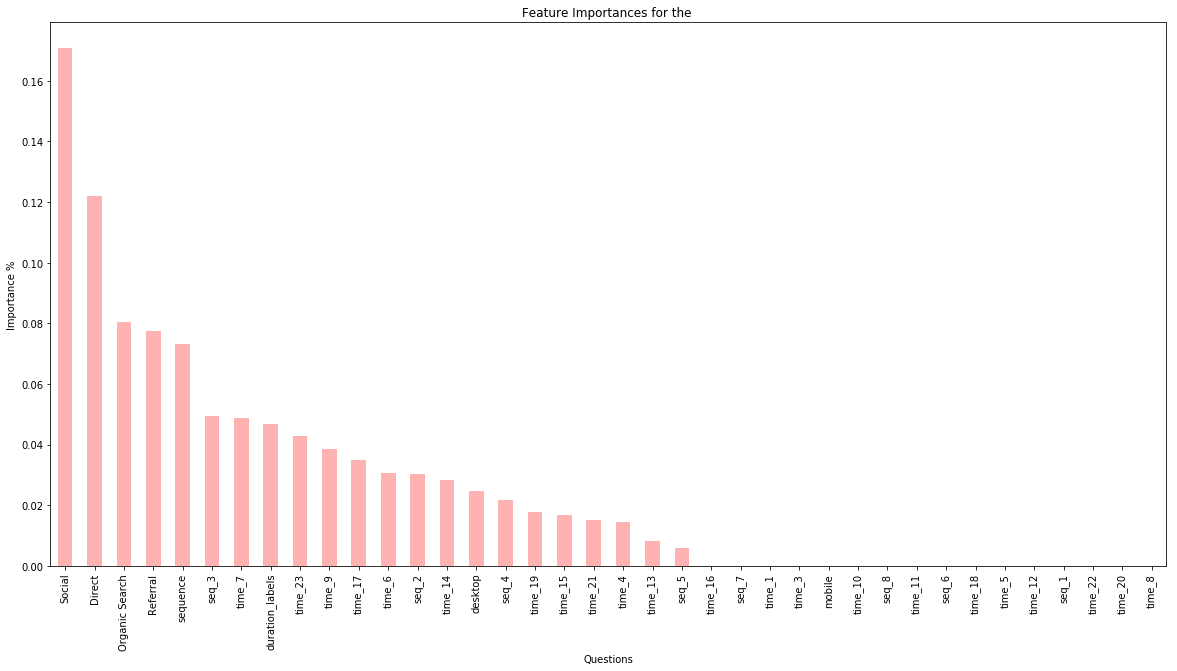

In [241]:
feature_imp = (XG.feature_importances_)

importances = pd.DataFrame([features,feature_imp])

final = importances.transpose()

final.columns = ['Questions', 'Importance %']

final = final.sort_values(by = 'Importance %', ascending = False)

final = final.set_index('Questions')



a = final['Importance %'].plot(kind = 'bar', color = 'r', alpha = .3,figsize=(20,10),label = 'Actual Strategy Outcomes (from test data)')
a.set_ylabel('Importance %')

a.set_title('Feature Importances for Predictive model ')

### Feature Importances

#### 1) By examining the features, the feature that had the greatest impact in determing the sequenced outcome is found.
#### 2) In this case for the most accurate model (KyleBoost), the channel labels was the features that had the greatest impact in reducing Gini. 

                Importance %
Features                    
Social              0.170718
Direct              0.121882
Organic Search     0.0804376
Referral           0.0773877
sequence           0.0731271
seq_3              0.0496042
time_7              0.048839
duration_labels    0.0468385
time_23            0.0428509
time_9             0.0385225
time_17            0.0351104
time_6             0.0306011
seq_2              0.0302698
time_14            0.0285059
desktop            0.0247059
seq_4              0.0218101
time_19            0.0178606
time_15            0.0169357
time_21            0.0151977
time_4             0.0146875
time_13           0.00823223
seq_5             0.00587549
time_16                    0
seq_7                      0
time_1                     0
time_3                     0
mobile                     0
time_10                    0
seq_8                      0
time_11                    0
seq_6                      0
time_18                    0
time_5        

ValueError: 'explode' must be of length 'x'

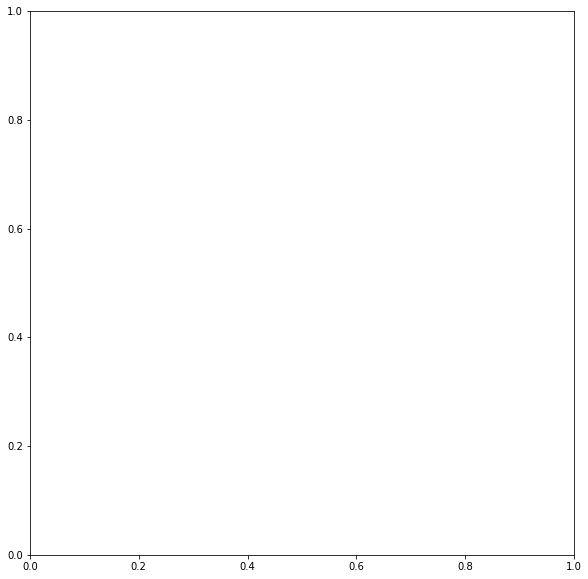

In [238]:
plt.figure(figsize = (15, 10))

feature_imp = (XG.feature_importances_)

features = X_train.columns

importances = pd.DataFrame([features,feature_imp])

final = importances.transpose()

final.columns = ['Features', 'Importance %']

final = final.sort_values(by = 'Importance %', ascending = False)

final = final.set_index('Features')

print(final)

#a = final['Importance %'].plot(kind = 'pie', color = 'r', alpha = .5,figsize=(20,10))

labels = features
sizes = feature_imp
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']
explode = (0, 0.1, 0, 0, 0) 

plt.pie(sizes, explode=explode, colors = colors, labels=labels, autopct='%1.1f%%', shadow=True, startangle=180)

plt.show()


## Setting up for Apyori Algorithm analyses

In [219]:
df_final = pd.DataFrame()

for session in np.unique(cfdc.new_session):
    
    a = session

    b = list(cfdc.page_title[cfdc.new_session == session])
    
    b.reverse()
    
    b.append('exit')
    
    dictionary = {a:b}

    df_1 = pd.DataFrame(dictionary)

    df_2 = df_1.transpose()

    df_final = pd.concat([df_final, df_2])
    


In [220]:
records = []

for i in range(0, len(df_final)):
    record = (([str(df_final.values[i,j]) for j in range(0, len(df_final.columns))]))
    
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)

    records.append(record)
    #records.remove('exit'), 'exit'

In [70]:
association_rules = ap(records, min_support = .0005, min_confidence = 1/(len(cfdc)), min_lift = .5, min_length = 2)

In [71]:
association_results = list(association_rules)
print(len(association_results))

275


In [72]:
final = pd.DataFrame()

for i in range(0, (len(association_results))):
    
    a = association_results[i]
    
    if len(a[0]) > 0:
        b = (pd.DataFrame(a[2]))
        final = pd.concat([final, b])
    

In [73]:
for item in association_results:
    pair = item[0]
    items = [x for x in pair]
   
    if (len(pair) > 1) & (len(pair) <= 2): 
        
        print('Rule: ' + str(items[0] + '-> '+ items[1] ) )

        print('Support: ' + str(item[1]))

        print('Confidence: ' + str(item[2][0][2]))
        print('Lift: ' + str(item[2][0][3]))

        print('Number of Occurrences: ' + str(item[1] * len(records)))
        
        print('=============================')
        
        
        
    elif (len(pair) > 2) & (len(pair) <= 4): 
        
        print('Rule: '+ items[2]   + '-> '+ items[1]  + '-> '+ str(items[0]))

        print('Support: ' + str(item[1]))

        print('Confidence: ' + str(item[2][0][2]))
        print('Lift: ' + str(item[2][0][3]))
        
        print('Number of Occurrences: ' + str(item[2] * len(records)))
        print('=============================')
        
      
    elif (len(pair) > 3) & (len(pair) <= 5 & (item[0] != 'exit')): 
        
        print('Rule: '+ items[0] + '-> '+ items[1] + '-> '+ items[2] + '-> '+ items[3]  + '-> '+ items[4] )

        print('Support: ' + str(item[1]))

        print('Confidence: ' + str(item[2][0][2]))
        print('Lift: ' + str(item[2][0][3]))
        
        #print('Number of Occurrences: ' + str(item[0] * len(records)))

        print('=============================')

      

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

